In [0]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt

In [0]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))      # 80% train, 20% validation

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)
# print(info)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples      # print(num_examples) = 23262
num_classes = info.features['label'].num_classes      # print(num_classes) = 2

The images in the Dogs vs. Cats dataset are not all the same size.

In [16]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).

So we need to reformat all images to the resolution expected by MobileNet (224, 224).

In [0]:
BATCH_SIZE = 32   # Number of training examples to process before updating our models variables
IMAGE_RES  = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

train_batches      = train_examples.shuffle(num_examples).map(format_image).batch(BATCH_SIZE)
validation_batches = validation_examples.shuffle(num_examples).map(format_image).batch(BATCH_SIZE)

To confirm that Training Images have been reshaped to 224  ×  224 pixels

In [18]:
for i, example_image in enumerate(train_batches.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (32, 224, 224, 3)
Image 2 shape: (32, 224, 224, 3)
Image 3 shape: (32, 224, 224, 3)


To confirm that Validation Images have been reshaped to 224  ×  224 pixels

In [19]:
for i, example_image in enumerate(validation_batches.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (32, 224, 224, 3)
Image 2 shape: (32, 224, 224, 3)
Image 3 shape: (32, 224, 224, 3)


# Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [0]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [22]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [23]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 3
r = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 86s 148ms/step - loss: 0.0517 - acc: 0.9834 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 82s 141ms/step - loss: 0.0305 - acc: 0.9906 - val_loss: 0.0313 - val_acc: 0.9881
Epoch 3/3
582/582 [==============================] - 81s 139ms/step - loss: 0.0248 - acc: 0.9923 - val_loss: 0.0314 - val_acc: 0.9877


### Visualizing results of the training

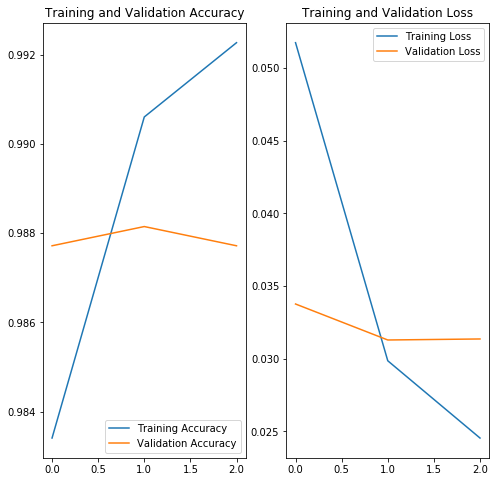

In [24]:
acc = r.history['acc']
val_acc = r.history['val_acc']

loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()